## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1>

In [6]:
# !pip install bayesian-optimization


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from bayes_opt import BayesianOptimization


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Функции </h1>  

In [8]:
# Отображение примеров изображений
def display_sample_images(dataset, class_name, n=7):
    plt.rcParams.update({'axes.grid': False})
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  # Берем одну партию данных
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_name)
            plt.axis("off")
    plt.show()

# Визуализация распределения классов
def plot_class_distribution(dataset):
    class_counts = {0: 0, 1: 0}  # 0: horses, 1: zebras
    for _, label in dataset:
        class_counts[label.numpy()] += 1
    plt.bar(class_counts.keys(), class_counts.values(), tick_label=["Horses", "Zebras"])
    plt.title("Class Distribution")
    plt.ylabel("Count")
    plt.show()

# Функция для аугментации изображений
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # Отражение по горизонтали
    image = tf.image.random_brightness(image, max_delta=0.2)  # Изменение яркости
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Изменение контрастности
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  #Случайные повороты
    return image, label

# Функция для добавления шума
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = image + noise
    return image, label

# Подготовка изображений
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0  # Нормализация для 8-битовых изображений
    return image, label

# Функция для создания обучающего и тестового датасетов
def split_dataset(dataset, train_fraction=0.8):
    dataset = dataset.shuffle(buffer_size=1000)  # Перемешиваем для случайного распределения
    dataset_size = sum(1 for _ in dataset)  # Подсчитываем количество элементов
    train_size = int(train_fraction * dataset_size)
    # take(n) возвращает новый датасет, содержащий первые n элементов
    train_dataset = dataset.take(train_size).batch(batch_size)
    # skip(n) возвращает новый датасет, пропуская первые n элементов
    test_dataset = dataset.skip(train_size).batch(batch_size)
    return train_dataset, test_dataset


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных</h1>

In [9]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses = dataset['trainA']
train_zebras = dataset['trainB']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.7KE35S_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.7KE35S_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.7KE35S_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.7KE35S_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


Horse images:


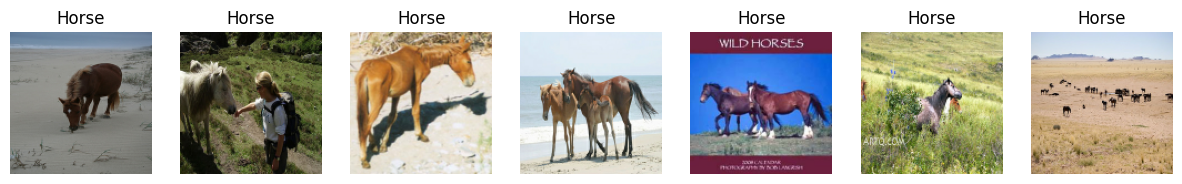

In [10]:
class_names = ['Horse', 'Zebra']
print("Horse images:")
display_sample_images(train_horses.map(preprocess).batch(32), class_names[0])


Zebra images:


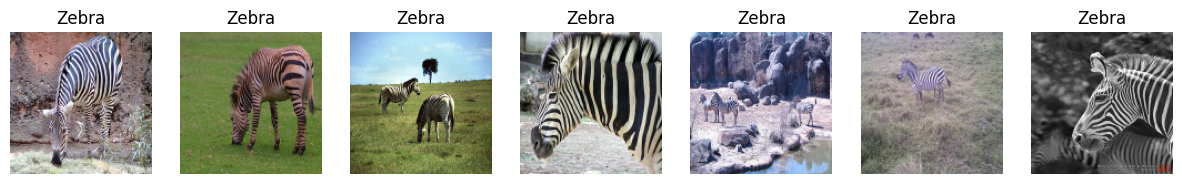

In [11]:
print("Zebra images:")
display_sample_images(train_zebras.map(preprocess).batch(32), class_names[1])


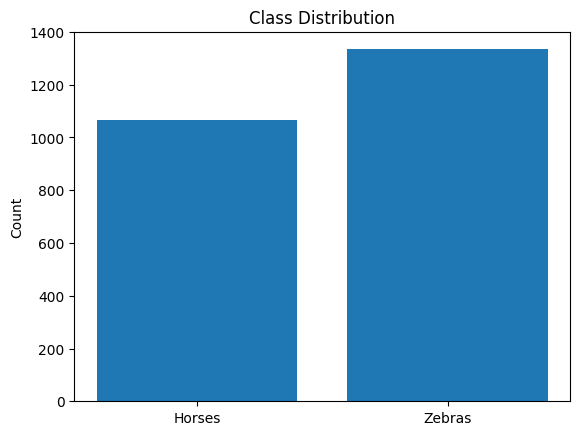

In [12]:
plot_class_distribution(train_horses.concatenate(train_zebras))


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Преобразование и подготовка данных</h1>

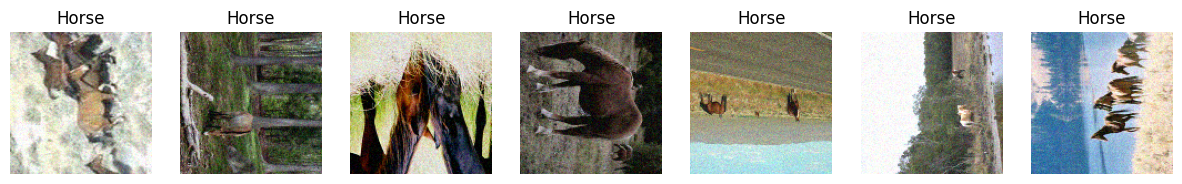

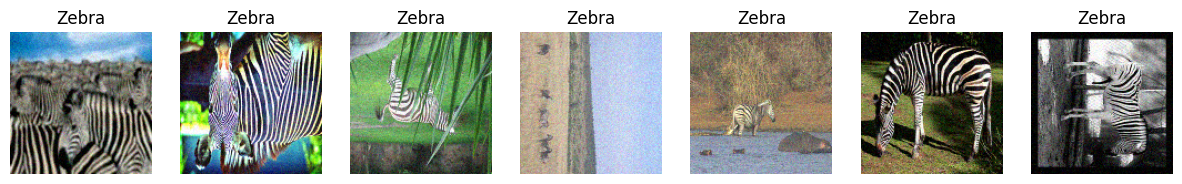

In [13]:
# Добавим метки классов (0 для лошадей и 1 для зебр)
train_horses = train_horses.map(lambda img, _: (img, 0))
train_zebras = train_zebras.map(lambda img, _: (img, 1))

# Аугментация данных
train_horses = train_horses.map(augment)
train_zebras = train_zebras.map(augment)

# Объединеним классы с балансировкой
dataset = tf.data.Dataset.sample_from_datasets(
    [train_horses, train_zebras],
    weights=[0.5, 0.5]  # Равное количество данных для каждого класса
)

# Стандартизируем размеры изображений и проведём нормализацию
dataset = dataset.map(preprocess)

# Добавим на изобарежния небольшое количество шума
dataset = dataset.map(add_noise)

# Перемешивание данных
dataset = dataset.shuffle(1000)

# Посмотрим на получившиеся изображения
horses_dataset_after = dataset.filter(lambda img, label: label == 0)
zebras_dataset_after = dataset.filter(lambda img, label: label == 1)
display_sample_images(horses_dataset_after.batch(32), "Horse")
display_sample_images(zebras_dataset_after.batch(32), "Zebra")


In [14]:
# Разделим датасет на обучающий и тестовый
batch_size = 32

train_dataset, test_dataset = split_dataset(dataset)
num_train_batches = sum(1 for _ in train_dataset)
num_test_batches = sum(1 for _ in test_dataset)

print(f'Количество обучающих батчей: {num_train_batches}')
print(f'Количество тестовых батчей: {num_test_batches}')


Количество обучающих батчей: 60
Количество тестовых батчей: 16


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение моделей</h1>

### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     60/Unknown 13s 97ms/step - accuracy: 0.5560 - loss: 2.5953

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.5562 - loss: 2.5772 - val_accuracy: 0.5696 - val_loss: 0.9831
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.5406 - loss: 1.2557 - val_accuracy: 0.5925 - val_loss: 1.3585
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.5706 - loss: 1.6107 - val_accuracy: 0.6840 - val_loss: 0.6261
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.6202 - loss: 0.6842 - val_accuracy: 0.5322 - val_loss: 0.7076
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.6282 - loss: 0.6644 - val_accuracy: 0.6237 - val_loss: 0.6669
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.6399 - loss: 0.6649 - val_accuracy: 0.6965 - val_loss: 0.5930
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.6042 - loss: 0.7391 - val_accuracy: 0.5759 - val_loss: 1.1351
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.5829 - loss: 0.8134 - val_accuracy: 0.657

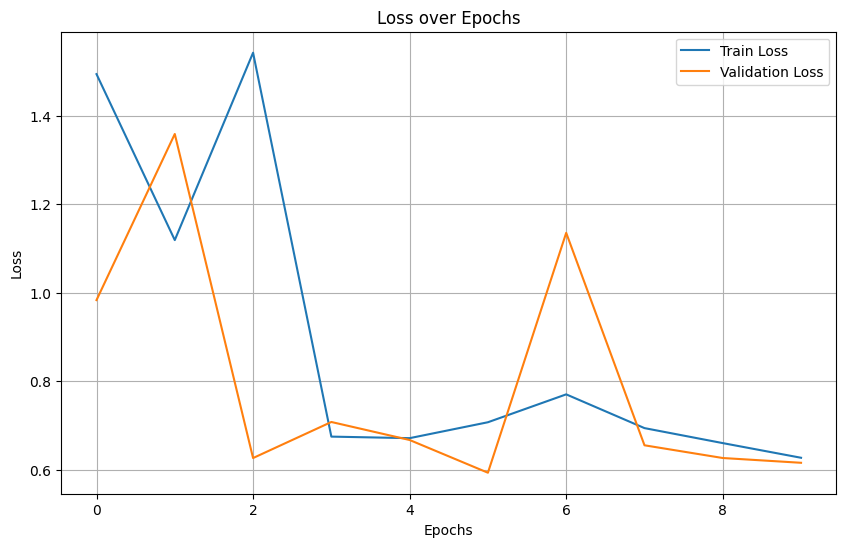

In [15]:
model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),  # Преобразует входные данные в одномерный вектор
    layers.Dense(128, activation='relu'),        # Первый скрытый слой с 128 нейронами и ReLU активацией
    layers.Dense(64, activation='relu'),         # Второй скрытый слой 64 нейронами и ReLU активацией
    layers.Dense(1, activation='sigmoid')        # Выходной слой с 1 нейроном и сигмоидной активацией (для бинарной классификации)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

train_loss, train_accuracy = model.evaluate(train_dataset)
print(f'Train\n Loss: {train_loss:.3f}, Accuracy: {train_accuracy:.3f}')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test\n Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}')

train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Подбор гиперапарметров через BayesianOptimization</h1>

In [19]:
def train_evaluate_model(neurons1, neurons2, learning_rate):
    model = models.Sequential([
        Input(shape=(128, 128, 3)),
        layers.Flatten(),
        layers.Dense(int(neurons1), activation='relu'),
        layers.Dense(int(neurons2), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=4, verbose=0)
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    return accuracy

pbounds = {
    'neurons1': (64, 256),
    'neurons2': (32, 128),
    'learning_rate': (1e-5, 1e-2)
}

optimizer = BayesianOptimization(
    f=train_evaluate_model,
    pbounds=pbounds,
    verbose=2, #вывод результатов всех итераций
    random_state=1
)

optimizer.maximize(init_points=5, n_iter=10)

best_params = optimizer.max['params']
print(f"Best parameters: {best_params}")


|   iter    |  target   | learni... | neurons1  | neurons2  |
-------------------------------------------------------------
| 1         | 0.6881    | 0.004176  | 202.3     | 32.01     |
| 2         | 0.7214    | 0.00303   | 92.18     | 40.86     |
| 3         | 0.5842    | 0.001871  | 130.3     | 70.09     |
| 4         | 0.6445    | 0.005393  | 144.5     | 97.78     |
| 5         | 0.422     | 0.002052  | 232.6     | 34.63     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 6         | 0.7006    | 0.006991  | 91.82     | 42.1      |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 7         | 0.6341    | 1e-05     | 97.79     | 32.0      |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 8         | 0.6403    | 1e-05     | 86.11     | 35.3      |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 9         | 0.6466    | 1e-05     | 99.77     | 41.95     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 10        | 0.6362    | 1e-05     | 192.9     | 32.32     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 11        | 0.5842    | 0.006287  | 205.4     | 40.41     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 12        | 0.4906    | 0.0001723 | 141.0     | 109.8     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 13        | 0.6237    | 0.01      | 149.5     | 88.13     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 14        | 0.6881    | 0.01      | 136.1     | 90.18     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 15        | 0.5717    | 0.01      | 127.9     | 91.38     |
Best parameters: {'learning_rate': 0.0030303024005920794, 'neurons1': 92.1771310368857, 'neurons2': 40.86450509780459}


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Нейросеть с наилучшими гиперпараметрами</h1>

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.5190 - loss: 10.1798 - val_accuracy: 0.4304 - val_loss: 3.7234
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.5667 - loss: 1.9942 - val_accuracy: 0.5988 - val_loss: 1.3185
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.5756 - loss: 1.4284 - val_accuracy: 0.6757 - val_loss: 0.6267
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.5825 - loss: 1.0350 - val_accuracy: 0.6216 - val_loss: 0.7827
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.6002 - loss: 0.7446 - val_accuracy: 0.4657 - val_loss: 1.0872
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.5703 - loss: 0.8706 - val_accuracy: 0.6715 - val_loss: 0.6364
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.5820 - loss: 0.7718 - val_accuracy: 0.6923 - val_loss: 0.5843
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.6823 - loss: 0.6235 - val_acc

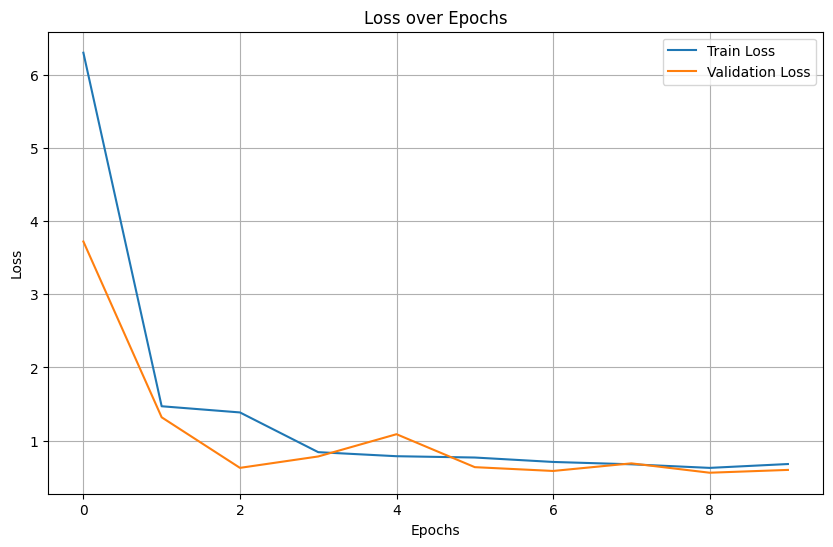

In [22]:
best_params = optimizer.max['params']
neurons1 = int(best_params['neurons1'])
neurons2 = int(best_params['neurons2'])
learning_rate = best_params['learning_rate']

model_best = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(neurons1, activation='relu'),
    layers.Dense(neurons2, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
optimizer_best = Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer_best,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_best = model_best.fit(train_dataset, epochs=10, validation_data=test_dataset, verbose=1)
loss_best, accuracy_best = model_best.evaluate(train_dataset)
print(f'Train with best parameters\n Loss: {loss_best:.3f}, Accuracy: {accuracy_best:.3f}')
loss_best, accuracy_best = model_best.evaluate(test_dataset)
print(f'Test with best parameters\n Loss: {loss_best:.3f}, Accuracy: {accuracy_best:.3f}')

train_loss_values = history_best.history['loss']
val_loss_values = history_best.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

